# Import

In [26]:
import tensorflow as tf
import tqdm

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

import numpy as np 
import matplotlib.pyplot as plt

#change the below line to your own path
log_files_path = 'C:/Users/Ali/logs/'

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Basic Structure of Batch Norm

In [27]:
def batch_norm_wrapper_1(inputs, is_training):

    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    if is_training:
        #calculate the mean and variance across the first dimention of inputs
        mean, var = tf.nn.moments(inputs,[0])
        ...
        # learn pop_mean and pop_var here
        ...
        
        #https://www.tensorflow.org/api_docs/python/tf/nn/batch_normalization
        #inputs: Input Tensor of arbitrary dimensionality.
        #mean: A mean Tensor.
        #variance: A variance Tensor.
        #offset: An offset Tensor, often denoted beta in equations, or None. If present, will be added to the normalized tensor.
        #scale: A scale Tensor, often denoted gamma in equations, or None. If present, the scale is applied to the normalized tensor.
        #variance_epsilon: A small float number to avoid dividing by 0.
        #name: A name for this operation (optional).
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)
    
    else:
        
        return tf.nn.batch_normalization(inputs, pop_mean, pop_var, beta, scale, epsilon)

# Full version of batch norm:  $\gamma\times\dfrac{(x-\mu)}{\sigma} + \beta$


# Simple version implemented with TensorFlow

In [28]:
def batch_norm_wrapper(inputs, is_training, decay = 0.999):
    """
    Implement batch normalization with input data
    input:
        inputs: Data to be batch normalized
        is_training: A boolean tensor indicates a training episode or testing one
        decay: The decaying rate of old variables. Used for estimating population mean and variance.
    output:
        output of tf.nn.batch_normalization
    """
    #scale(gamma), offset(beta), mean and variance have the same shape as inputs' last dimention
    scale = tf.Variable(tf.ones([inputs.get_shape()[-1]]))
    beta = tf.Variable(tf.zeros([inputs.get_shape()[-1]]))
    
    #The trainable parameter of pop_mean and pop_var is set to be False, so thet won't be auto-updated in testing episode
    #Trainable=False doesn't mean unchangable
    pop_mean = tf.Variable(tf.zeros([inputs.get_shape()[-1]]), trainable=False)
    pop_var = tf.Variable(tf.ones([inputs.get_shape()[-1]]), trainable=False)

    if is_training:
        #calculate the batch mean and variance by tf.nn.moments which returns two tensors
        batch_mean, batch_var = tf.nn.moments(inputs,[0])
        #keep update population's mean and variance
        train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
        train_var  = tf.assign(pop_var,  pop_var * decay + batch_var * (1 - decay))
        #in training episode, train_mean and train_var have to be updated first by tf.control_dependencies, then return the output of batch_normalization
        #https://www.tensorflow.org/api_docs/python/tf/Graph#control_dependencies
        with tf.control_dependencies([train_mean, train_var]):
            
            return tf.nn.batch_normalization(inputs,
                batch_mean, batch_var, beta, scale, epsilon)
            
    else:
        return tf.nn.batch_normalization(inputs,
            pop_mean, pop_var, beta, scale, epsilon)
    
def build_graph(is_training):
    """
    Build the structure of a fully-connected two layers' neural network with batch_normalizition by using tensorflow
    """
    # Placeholders
    x = tf.placeholder(tf.float32, shape=[None, 784])
    y_ = tf.placeholder(tf.float32, shape=[None, 10])

    # Layer 1 with batch norm
    w1 = tf.Variable(w1_initial)
    z1 = tf.matmul(x,w1)
    bn1 = batch_norm_wrapper(z1, is_training)
    l1 = tf.nn.sigmoid(bn1)

    #Layer 2 with batch norm
    w2 = tf.Variable(w2_initial)
    z2 = tf.matmul(l1,w2)
    bn2 = batch_norm_wrapper(z2, is_training)
    l2 = tf.nn.sigmoid(bn2)

    # Softmax. No batch norm in Softmax layer
    w3 = tf.Variable(w3_initial)
    b3 = tf.Variable(tf.zeros([10]))
    y  = tf.nn.softmax(tf.matmul(l2, w3))

    # Loss, Optimizer and Predictions
    cross_entropy = -tf.reduce_sum(y_*tf.log(y))

    train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
    # Evaluation
    correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))
    
    return (x, y_), train_step, accuracy, y, tf.train.Saver()

# Now let's do batch norm by hand
In this section, we will build two neural networks simultaneously: W/O and W/ Batch Norm, then compare the accuracy of them.
## Build Graph

In [29]:
# Generate predetermined random weights so the networks are similarly initialized
w1_initial = np.random.normal(size=(784,100)).astype(np.float32)
w2_initial = np.random.normal(size=(100,100)).astype(np.float32)
w3_initial = np.random.normal(size=(100,10)).astype(np.float32)

# Small epsilon value for the BN transform: variance_epsilon: A small float number to avoid dividing by 0.
epsilon = 1e-3

# Placeholders
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])


# -------------------------------------
# Layer 1 without Batch Normalization
w1 = tf.Variable(w1_initial)
b1 = tf.Variable(tf.zeros([100]))
z1 = tf.matmul(x,w1)+b1
l1 = tf.nn.sigmoid(z1)


#--------------------------------------
# Layer 1 with Batch Normalization
w1_BN = tf.Variable(w1_initial)
# Note that pre-batch normalization bias is ommitted. 
# The effect of this bias would be eliminated when subtracting the batch mean. 
# Instead, the role of the bias is performed by the new beta variable.
z1_BN = tf.matmul(x, w1_BN)
# Calculate batch mean and variance
[batch_mean1, batch_var1] = tf.nn.moments(z1_BN,[0])
# Apply the initial batch normalizing transform
z1_hat = (z1_BN - batch_mean1) / tf.sqrt(batch_var1 + epsilon)
# Create two new parameters, scale and beta (shift)
scale1 = tf.Variable(tf.ones([100]))
beta1  = tf.Variable(tf.zeros([100]))
# Scale and shift to obtain the final output of the batch normalization
# this value is fed into the activation function (here a sigmoid)
BN1   = scale1 * z1_hat + beta1
l1_BN = tf.nn.sigmoid(BN1)


# -------------------------------------
# Layer 2 without Batch Normalization
w2 = tf.Variable(w2_initial)
b2 = tf.Variable(tf.zeros([100]))
z2 = tf.matmul(l1,w2)+b2
l2 = tf.nn.sigmoid(z2)


# -----------------------------------------
# Layer 2 with Batch Normalization
# using Tensorflows built-in Batch Normalization function
w2_BN = tf.Variable(w2_initial)
z2_BN = tf.matmul(l1_BN,w2_BN)
batch_mean2, batch_var2 = tf.nn.moments(z2_BN,[0])
scale2 = tf.Variable(tf.ones([100]))
beta2 = tf.Variable(tf.zeros([100]))

BN2 = tf.nn.batch_normalization(z2_BN, batch_mean2, batch_var2, beta2, scale2, epsilon)
l2_BN = tf.nn.sigmoid(BN2)



# Softmax
w3 = tf.Variable(w3_initial)
b3 = tf.Variable(tf.zeros([10]))
y  = tf.nn.softmax(tf.matmul(l2,w3)+b3)

w3_BN = tf.Variable(w3_initial)
b3_BN = tf.Variable(tf.zeros([10]))
y_BN  = tf.nn.softmax(tf.matmul(l2_BN, w3_BN) + b3_BN)

# Loss, optimizer and predictions
cross_entropy    = -tf.reduce_sum(y_*tf.log(y))
cross_entropy_BN = -tf.reduce_sum(y_*tf.log(y_BN))

train_step    = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy)
train_step_BN = tf.train.GradientDescentOptimizer(0.01).minimize(cross_entropy_BN)

#Evaluation of neural network without BN
correct_prediction = tf.equal(tf.arg_max(y,1),tf.arg_max(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

#Evaluation of neural network with BN
correct_prediction_BN = tf.equal(tf.arg_max(y_BN,1),tf.arg_max(y_,1))
accuracy_BN = tf.reduce_mean(tf.cast(correct_prediction_BN,tf.float32))

## Parameters

In [30]:
num_examples = 200
training_size = 40000
batch_size = 50
epochs = 10000

## Training and Testing

100%|██████████| 40000/40000 [03:15<00:00, 205.12it/s]


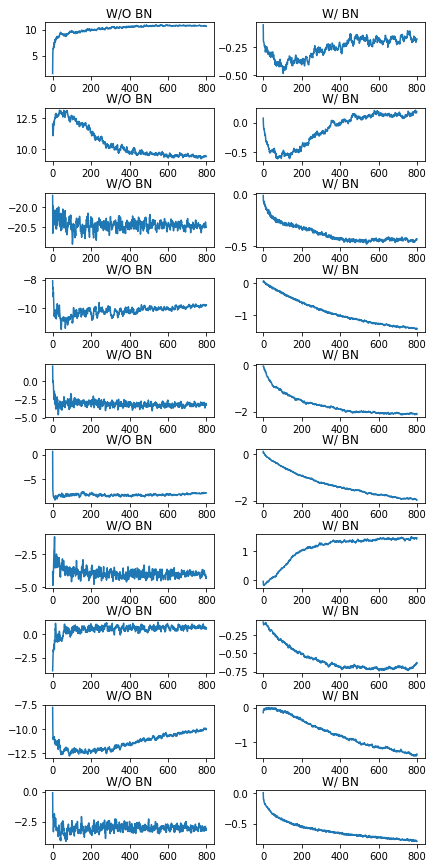

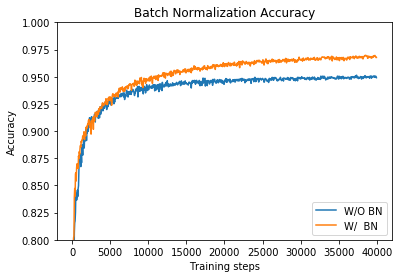

In [31]:
#Training the network
#zs record the mean value of z2 over the entire test set
#BNs record the mean value of BN2 over the entire test set
zs, BNs, acc, acc_BN = [], [], [], []

sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
for i in tqdm.tqdm(range(training_size)):
    #you will need to write your own next_batch function in the real world
    batch = mnist.train.next_batch(batch_size)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
    train_step_BN.run(feed_dict={x: batch[0], y_: batch[1]})
    if i % 50 is 0:
        res = sess.run([accuracy, accuracy_BN, z2, BN2], feed_dict={x: mnist.test.images, y_: mnist.test.labels})
        acc.append(res[0])
        acc_BN.append(res[1])
        zs.append(np.mean(res[2],axis=0)) 
        BNs.append(np.mean(res[3],axis=0)) 

[zs, BNs, acc, acc_BN] = np.array(zs), np.array(BNs), np.array(acc), np.array(acc_BN)

fig, ax = plt.subplots()

# plot accuracy against each other
ax.plot(range(0,len(acc)*50,50),acc,    label='W/O BN')
ax.plot(range(0,len(acc)*50,50),acc_BN, label='W/  BN')
ax.set_xlabel('Training steps')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.8,1])
ax.set_title('Batch Normalization Accuracy')
ax.legend(loc=4)
plt.show()

# distribution over time of the inputs to the sigmoid activation 
# function of the first ten neurons in the second layer
[fig, axes] = plt.subplots(10, 2, figsize=(6,12))
fig.tight_layout()

for i, ax in enumerate(axes):
    ax[0].set_title("W/O BN")
    ax[1].set_title("W/ BN")
    ax[0].plot(zs[:,i])
    ax[1].plot(BNs[:,i])

Try predicting the test data one by one without updating mean_BN and var_BN

In [32]:
predictions = []
cum_corr = 0

for i in range(num_examples):
    [pred, corr] = sess.run([tf.arg_max(y_BN,1), accuracy_BN], feed_dict={x: [mnist.test.images[i]], y_: [mnist.test.labels[i]]})
    cum_corr += corr
    predictions.append(pred[0])

#Inputs to the activation functions will always be the same
# since they are normalized to have the same mean & always get the same prediction
#no matter what inputs are
print("Predictions (1):", predictions)
print("Accuracy (1):", cum_corr/num_examples)


sess.close()

Predictions (1): [8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]
Accuracy (1): 0.05


## Fixing the model for test time
Have to replace mean & variance in each batch normalization step with estimates of the population mean and population variance
Use an exponential moving average to estimate the population mean and variance during training

In [33]:
#decay = 0.999 # use numbers closer to 1 if you have more data
#train_mean = tf.assign(pop_mean, pop_mean * decay + batch_mean * (1 - decay))
#train_var = tf.assign(pop_var, pop_var * decay + batch_var * (1 - decay))
#we've already set them in the build_graph function

tf.reset_default_graph()
(x, y_), train_step, accuracy, _, saver = build_graph(is_training=True)
acc = []
with tf.Session() as sess:
    
    sess.run(tf.global_variables_initializer())
    
    for i in tqdm.tqdm(range(epochs)):
        batch = mnist.train.next_batch(batch_size)
        train_step.run(feed_dict={x: batch[0], y_: batch[1]})
        if i % 100 is 0:
            res = sess.run([accuracy],feed_dict={x: mnist.test.images, y_: mnist.test.labels})
            acc.append(res[0])
            
    saved_model = saver.save(sess, log_files_path+'batch_normalization/')

print("Final accuracy:", acc[-1])

#Repeat the experiment of predicting examples one by one to show that it worked
tf.reset_default_graph()
(x, y_), _, accuracy, y, saver = build_graph(is_training=False)

predictions = []
cum_corr = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, log_files_path + 'batch_normalization/')
    for i in range(num_examples):
        [pred, corr] = sess.run([tf.arg_max(y,1), accuracy], feed_dict={x: [mnist.test.images[i]], y_: [mnist.test.labels[i]]})
        cum_corr += corr
        predictions.append(pred[0])
print("Predictions (2):", predictions)
print("Accuracy (2):", cum_corr/num_examples)

100%|██████████| 10000/10000 [00:25<00:00, 395.57it/s]


Final accuracy: 0.9476
INFO:tensorflow:Restoring parameters from C:/Users/Ali/logs/batch_normalization/
Predictions (2): [7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 0, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 2, 9, 3, 7, 4, 7, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 4, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 9, 9, 8, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 9, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 4, 0, 3, 1, 6, 4, 2]
Accuracy (2): 0.955
